# Chapter 4.3. Batch Normalization TensorFlow

Original code in Nikolenko book was made in **TensorFlow 1.x (TF1)**, but here I will convert examples to **TensorFlow 2.0 (TF2)**.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm

from metrics import accuracy
from utils import (
    _fix_seeds,
    plot_metric_history,
    show_images
)
from models_classes import (
    BNModel1,
    BNModel2
)

matplotlib.style.use('seaborn-poster')

## 1. Load data

- MNIST have 70k images (1 channel) with size of 28x28 (784 if flatten). 
- Samples have already splitted into train (60k images) and test (10k images). 
- Target classes in categorical view

In [2]:
mnist = tf.keras.datasets.mnist.load_data()
(X_train, y_train), (X_test, y_test) = mnist
X_train, X_test = X_train / 255.0, X_test / 255.0

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

X_train = tf.cast(X_train.reshape(-1, 784), tf.float32)
y_train = tf.cast(tf.one_hot(y_train, 10), tf.float32)

X_test = tf.cast(X_test.reshape(-1, 784), tf.float32)
y_test = tf.cast(tf.one_hot(y_test, 10), tf.float32)   

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)
(60000, 784) (60000, 10)
(10000, 784) (10000, 10)


## 2. Train and evaluate simple model 100 times with and without batch normalization

In [3]:
# define train proces
def train(model, X, y, optimizer):
    """
    One step of train process
    
    params:
        model: model object to train
        X: data
        y: target 
        optimizer: tf optimizer
    return:
        loss_val: loss value
    """
    with tf.GradientTape() as t:
        y_pred_logit = model(X)
        loss_val = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y, y_pred_logit))
        
    grads = t.gradient(loss_val, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    acc = accuracy(y, tf.nn.softmax(y_pred_logit))
    
    return loss_val, acc


# define evaluate proces
def evaluate(model, X, y):
    """
    One step of evaluation process
    
    params:
        model: model object to evaluate
        X: data to evaluate
        y: target 
    return:
        loss_val: loss value
    """
    y_pred_logit = model(X)
    loss_val = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y, y_pred_logit))
    
    acc = accuracy(y, tf.nn.softmax(y_pred_logit))
    
    return loss_val, acc


def one_experiment(X_train, y_train, X_test, y_test, \
                   model, optimizer, 
                   num_steps=1000, batch_size=128):
    """
    Run one experiment.
    
    returns:
        loss_history: dict of lists
        acc_history: dict of lists
    """
    # collect metrics
    loss_history = {
        'train': [],
        'test': []
    }
    acc_history = {
        'train': [],
        'test': []
    }

    # running optimization
    for i in range(num_steps):

        # select train data batch
        indices = np.random.choice(len(X_train), batch_size)
        X_train_batch, y_train_batch = tf.gather(X_train, indices, axis=0), tf.gather(y_train, indices, axis=0)

        # train model
        train_loss, train_acc = train(model, X_train_batch, y_train_batch, optimizer)

        # select test data batch
        indices = np.random.choice(len(X_test), batch_size)
        X_test_batch, y_test_batch = tf.gather(X_test, indices, axis=0), tf.gather(y_test, indices, axis=0)  

        # evaluate model
        test_loss, test_acc = evaluate(model, X_test_batch, y_test_batch)

        # collect current metrics
        loss_history['train'].append(train_loss.numpy())
        loss_history['test'].append(test_loss.numpy())
        acc_history['train'].append(train_acc)
        acc_history['test'].append(test_acc)
        
    return loss_history, acc_history

### 2.1. Model 1: with BN

In [5]:
%%time
# set constants
_fix_seeds(42)

lr = 1e-2
batch_size = 128
num_steps = 1000
repeat_num = 100

loss_history_exp = []
acc_history_exp = []

for j in tqdm(range(repeat_num)):
    
    # Set up model and optimier
    model1 = BNModel1()
    optimizer = tf.optimizers.Adam(learning_rate=lr)

    loss_history, acc_history = one_experiment(X_train, y_train, X_test, y_test, \
                                               model1, optimizer, 
                                               num_steps=num_steps,
                                               batch_size=batch_size)
        
    loss_history_exp.append(loss_history)
    acc_history_exp.append(acc_history)

100%|██████████| 100/100 [17:49<00:00, 10.70s/it]

CPU times: user 26min 52s, sys: 1min 22s, total: 28min 15s
Wall time: 17min 49s


In [6]:
loss_plain_mtrx = {
    'train':[],
    'test':[]
}
acc_plain_mtrx = {
    'train':[],
    'test':[]    
}

for exp_loss, exp_acc in zip(loss_history_exp, acc_history_exp):
    loss_plain_mtrx['train'].append(exp_loss['train'])
    loss_plain_mtrx['test'].append(exp_loss['test'])
    
    acc_plain_mtrx['train'].append(exp_acc['train'])
    acc_plain_mtrx['test'].append(exp_acc['test']) 
    
loss_plain_mtrx['train'] = np.array(loss_plain_mtrx['train'])
loss_plain_mtrx['test'] = np.array(loss_plain_mtrx['test'])

acc_plain_mtrx['train'] = np.array(acc_plain_mtrx['train'])
acc_plain_mtrx['test'] = np.array(acc_plain_mtrx['test'])

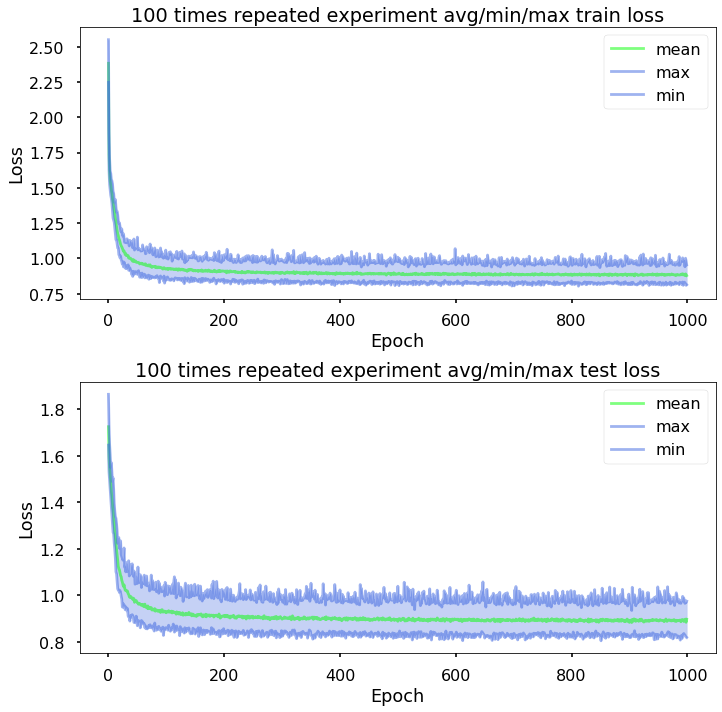

In [7]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

ax[0].plot(loss_plain_mtrx['train'].mean(axis=0), label='mean', alpha=0.5, c='lime')
ax[0].plot(loss_plain_mtrx['train'].max(axis=0), label='max', alpha=0.5, c='royalblue')
ax[0].plot(loss_plain_mtrx['train'].min(axis=0), label='min', alpha=0.5, c='royalblue')  
ax[0].fill_between(list(range(1000)), 
                 loss_plain_mtrx['train'].max(axis=0),
                 loss_plain_mtrx['train'].min(axis=0), alpha=0.3, color='royalblue')

ax[0].set_title('100 times repeated experiment avg/min/max train loss' )
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(loss_plain_mtrx['test'].mean(axis=0), label='mean', alpha=0.5, c='lime')
ax[1].plot(loss_plain_mtrx['test'].max(axis=0), label='max', alpha=0.5, c='royalblue')
ax[1].plot(loss_plain_mtrx['test'].min(axis=0), label='min', alpha=0.5, c='royalblue')  
ax[1].fill_between(list(range(1000)), 
                 loss_plain_mtrx['test'].max(axis=0),
                 loss_plain_mtrx['test'].min(axis=0), alpha=0.3, color='royalblue')

ax[1].set_title('100 times repeated experiment avg/min/max test loss' )
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
plt.tight_layout()
plt.show()

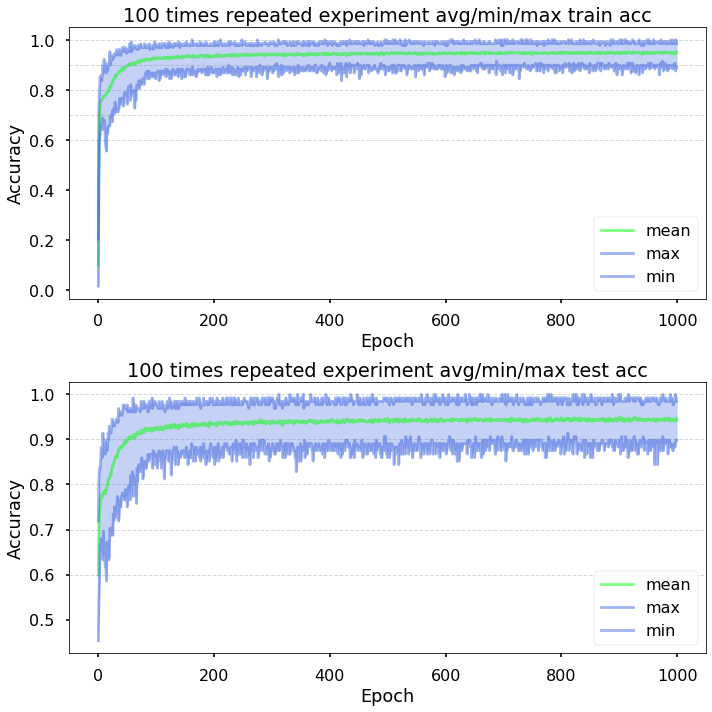

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

ax[0].axhline(y=1.0, c='grey', alpha=0.3, ls='--', lw=1)
ax[0].axhline(y=0.9, c='grey', alpha=0.3, ls='--', lw=1)
ax[0].axhline(y=0.8, c='grey', alpha=0.3, ls='--', lw=1)
ax[0].axhline(y=0.7, c='grey', alpha=0.3, ls='--', lw=1)
ax[0].axhline(y=0.6, c='grey', alpha=0.3, ls='--', lw=1)

ax[0].plot(acc_plain_mtrx['train'].mean(axis=0), label='mean', alpha=0.5, c='lime')
ax[0].plot(acc_plain_mtrx['train'].max(axis=0), label='max', alpha=0.5, c='royalblue')
ax[0].plot(acc_plain_mtrx['train'].min(axis=0), label='min', alpha=0.5, c='royalblue')  
ax[0].fill_between(list(range(1000)), 
                 acc_plain_mtrx['train'].max(axis=0),
                 acc_plain_mtrx['train'].min(axis=0), alpha=0.3, color='royalblue')

ax[0].set_title('100 times repeated experiment avg/min/max train acc' )
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].axhline(y=1.0, c='grey', alpha=0.3, ls='--', lw=1)
ax[1].axhline(y=0.9, c='grey', alpha=0.3, ls='--', lw=1)
ax[1].axhline(y=0.8, c='grey', alpha=0.3, ls='--', lw=1)
ax[1].axhline(y=0.7, c='grey', alpha=0.3, ls='--', lw=1)
ax[1].axhline(y=0.6, c='grey', alpha=0.3, ls='--', lw=1)

ax[1].plot(acc_plain_mtrx['test'].mean(axis=0), label='mean', alpha=0.5, c='lime')
ax[1].plot(acc_plain_mtrx['test'].max(axis=0), label='max', alpha=0.5, c='royalblue')
ax[1].plot(acc_plain_mtrx['test'].min(axis=0), label='min', alpha=0.5, c='royalblue')  
ax[1].fill_between(list(range(1000)), 
                 acc_plain_mtrx['test'].max(axis=0),
                 acc_plain_mtrx['test'].min(axis=0), alpha=0.3, color='royalblue')

ax[1].set_title('100 times repeated experiment avg/min/max test acc' )
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.tight_layout()
plt.show()

### 2.2 Model 2: without BN

In [9]:
%%time
# set constants
_fix_seeds(42)

lr = 1e-2
batch_size = 128
num_steps = 1000
repeat_num = 100

loss_history_exp = []
acc_history_exp = []

for j in tqdm(range(repeat_num)):
    
    # Set up model and optimier
    model2 = BNModel2()
    optimizer = tf.optimizers.Adam(learning_rate=lr)

    loss_history, acc_history = one_experiment(X_train, y_train, X_test, y_test, \
                                               model2, optimizer, 
                                               num_steps=num_steps,
                                               batch_size=batch_size)
        
    loss_history_exp.append(loss_history)
    acc_history_exp.append(acc_history)

100%|██████████| 100/100 [12:02<00:00,  7.23s/it]

CPU times: user 20min 22s, sys: 1min 11s, total: 21min 34s
Wall time: 12min 2s


In [10]:
loss_plain_mtrx = {
    'train':[],
    'test':[]
}
acc_plain_mtrx = {
    'train':[],
    'test':[]    
}

for exp_loss, exp_acc in zip(loss_history_exp, acc_history_exp):
    loss_plain_mtrx['train'].append(exp_loss['train'])
    loss_plain_mtrx['test'].append(exp_loss['test'])
    
    acc_plain_mtrx['train'].append(exp_acc['train'])
    acc_plain_mtrx['test'].append(exp_acc['test']) 
    
loss_plain_mtrx['train'] = np.array(loss_plain_mtrx['train'])
loss_plain_mtrx['test'] = np.array(loss_plain_mtrx['test'])

acc_plain_mtrx['train'] = np.array(acc_plain_mtrx['train'])
acc_plain_mtrx['test'] = np.array(acc_plain_mtrx['test'])

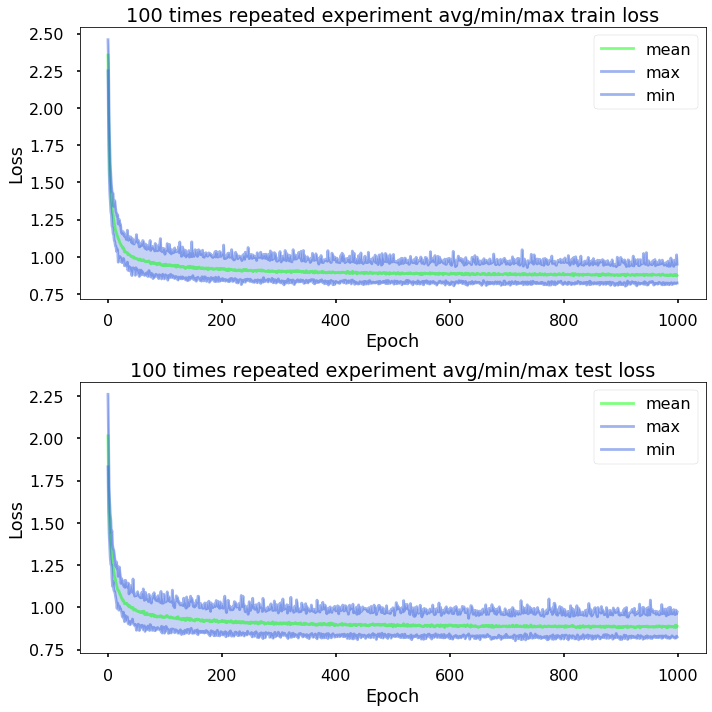

In [11]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

ax[0].plot(loss_plain_mtrx['train'].mean(axis=0), label='mean', alpha=0.5, c='lime')
ax[0].plot(loss_plain_mtrx['train'].max(axis=0), label='max', alpha=0.5, c='royalblue')
ax[0].plot(loss_plain_mtrx['train'].min(axis=0), label='min', alpha=0.5, c='royalblue')  
ax[0].fill_between(list(range(1000)), 
                 loss_plain_mtrx['train'].max(axis=0),
                 loss_plain_mtrx['train'].min(axis=0), alpha=0.3, color='royalblue')

ax[0].set_title('100 times repeated experiment avg/min/max train loss' )
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(loss_plain_mtrx['test'].mean(axis=0), label='mean', alpha=0.5, c='lime')
ax[1].plot(loss_plain_mtrx['test'].max(axis=0), label='max', alpha=0.5, c='royalblue')
ax[1].plot(loss_plain_mtrx['test'].min(axis=0), label='min', alpha=0.5, c='royalblue')  
ax[1].fill_between(list(range(1000)), 
                 loss_plain_mtrx['test'].max(axis=0),
                 loss_plain_mtrx['test'].min(axis=0), alpha=0.3, color='royalblue')

ax[1].set_title('100 times repeated experiment avg/min/max test loss' )
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
plt.tight_layout()
plt.show()

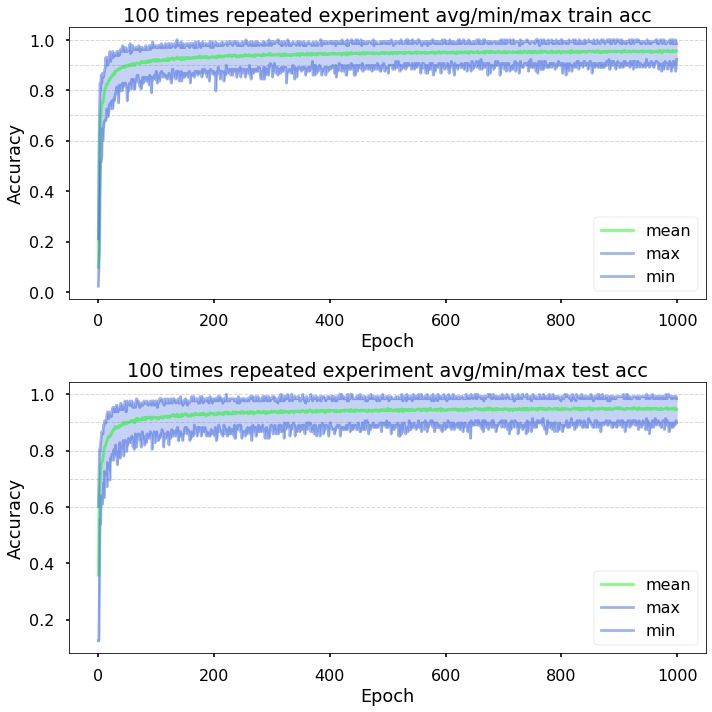

In [12]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

ax[0].axhline(y=1.0, c='grey', alpha=0.3, ls='--', lw=1)
ax[0].axhline(y=0.9, c='grey', alpha=0.3, ls='--', lw=1)
ax[0].axhline(y=0.8, c='grey', alpha=0.3, ls='--', lw=1)
ax[0].axhline(y=0.7, c='grey', alpha=0.3, ls='--', lw=1)
ax[0].axhline(y=0.6, c='grey', alpha=0.3, ls='--', lw=1)

ax[0].plot(acc_plain_mtrx['train'].mean(axis=0), label='mean', alpha=0.5, c='lime')
ax[0].plot(acc_plain_mtrx['train'].max(axis=0), label='max', alpha=0.5, c='royalblue')
ax[0].plot(acc_plain_mtrx['train'].min(axis=0), label='min', alpha=0.5, c='royalblue')  
ax[0].fill_between(list(range(1000)), 
                 acc_plain_mtrx['train'].max(axis=0),
                 acc_plain_mtrx['train'].min(axis=0), alpha=0.3, color='royalblue')

ax[0].set_title('100 times repeated experiment avg/min/max train acc' )
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].axhline(y=1.0, c='grey', alpha=0.3, ls='--', lw=1)
ax[1].axhline(y=0.9, c='grey', alpha=0.3, ls='--', lw=1)
ax[1].axhline(y=0.8, c='grey', alpha=0.3, ls='--', lw=1)
ax[1].axhline(y=0.7, c='grey', alpha=0.3, ls='--', lw=1)
ax[1].axhline(y=0.6, c='grey', alpha=0.3, ls='--', lw=1)

ax[1].plot(acc_plain_mtrx['test'].mean(axis=0), label='mean', alpha=0.5, c='lime')
ax[1].plot(acc_plain_mtrx['test'].max(axis=0), label='max', alpha=0.5, c='royalblue')
ax[1].plot(acc_plain_mtrx['test'].min(axis=0), label='min', alpha=0.5, c='royalblue')  
ax[1].fill_between(list(range(1000)), 
                 acc_plain_mtrx['test'].max(axis=0),
                 acc_plain_mtrx['test'].min(axis=0), alpha=0.3, color='royalblue')

ax[1].set_title('100 times repeated experiment avg/min/max test acc' )
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.tight_layout()
plt.show()